In [1]:
rm(list=ls())

library(DoubleML)
library(ggplot2)
library(mlr3)
library(mlr3learners)
library(repr)
library(data.table)
library(mvtnorm)
library(clusterGeneration)
suppressMessages(library(parallel))
suppressMessages(library(ggplot2))
suppressMessages(library(doMC))
lgr::get_logger("mlr3")$set_threshold("warn")

numCores <- detectCores()
registerDoMC(cores = numCores)

Loading required package: MASS



In [2]:
generate_turrellDGP <- function(n_obs,dim_x,theta,seed,nu=0,gamma=1) {
    
    m = function(x, nu = 0, gamma = 1) {
        y = 0.5 / pi * sinh(gamma) / (cosh(gamma) - cos(x - nu))
        return(y)
    }
    
    g = function(x) {
        y = sin(x)^2
        return(y)
    }
    
    set.seed(seed)
    b = 1 / (1:dim_x)
    sigma = genPositiveDefMat(dim_x)
    x = rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = sigma$Sigma)
    G = g(x %*% b)
    M = m(x %*% b, nu = nu, gamma = gamma)
    d = M + rnorm(n_obs)
    y = as.matrix(theta * d + G + rnorm(n_obs))

    # Data prep
    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
}

In [3]:
# LASSO Estimation Function
est_lasso <- function(obj_dml_data) {
    
    set.seed(70)
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  
    m_hat <- learner$clone()
    
    DML_PLR4  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=4)   
    DML_PLR4$fit()                                            
    theta_4 <- DML_PLR4$coef
    
    DML_PLR5  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=5)   
    DML_PLR5$fit()                                            
    theta_5 <- DML_PLR5$coef
    
    DML_PLR6  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=6)   
    DML_PLR6$fit()                                            
    theta_6 <- DML_PLR6$coef
    
    DML_PLR8  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=8)   
    DML_PLR8$fit()                                            
    theta_8 <- DML_PLR8$coef
          
    DML_PLR10  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat, n_folds=10)   
    DML_PLR10$fit()                                            
    theta_10 <- DML_PLR10$coef

    theta_estims    <- cbind(theta_4,theta_5,theta_6,theta_8,theta_10)
    return(theta_estims)
}

In [4]:
# Simulation function: Take in generate_data, spit out estimates for theta coef and sd
sim_function <- function(data){
    
    DML_data    <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    coef_output <- est_lasso(DML_data) 
    return(coef_output)
}

In [5]:
### Fixed Design Parameters
n_rep  = 100
n_vars = 200
theta  = 1

# Varied k and sample size
sample_size <- seq(30, 300, by = 10)

In [6]:
iterations = vector("list",length(sample_size))

for (i in 1:length(sample_size)) {
    
    boot_fx <- function(iteration) {        
        #data        <- generate_DGP(theta=theta,n_obs=sample_size[i],dim_x=n_vars,seed=iteration)
        data        <- generate_turrellDGP(n_obs=sample_size[i],dim_x=n_vars,theta,seed=iteration,nu=0.2,gamma=0.8)
        theta_estim <- sim_function(data) 
        return(theta_estim) 
    }
    
    parallel_estims <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    iterations[[i]] <- do.call(rbind, parallel_estims)

}

In [9]:
bias_matrix <- matrix(NA, ncol = dim(iterations[[1]])[2], nrow = length(sample_size))
var_matrix <- matrix(NA, ncol =  dim(iterations[[1]])[2], nrow = length(sample_size))

mse <- function(x){   
    return (mean((x - theta)^2)) 
}

for (i in 1:length(sample_size)) {
    bias_matrix[i,] <- abs(colMeans(iterations[[i]]) - 1)
    var_matrix[i,]  <- apply(iterations[[i]], 2, var)
}

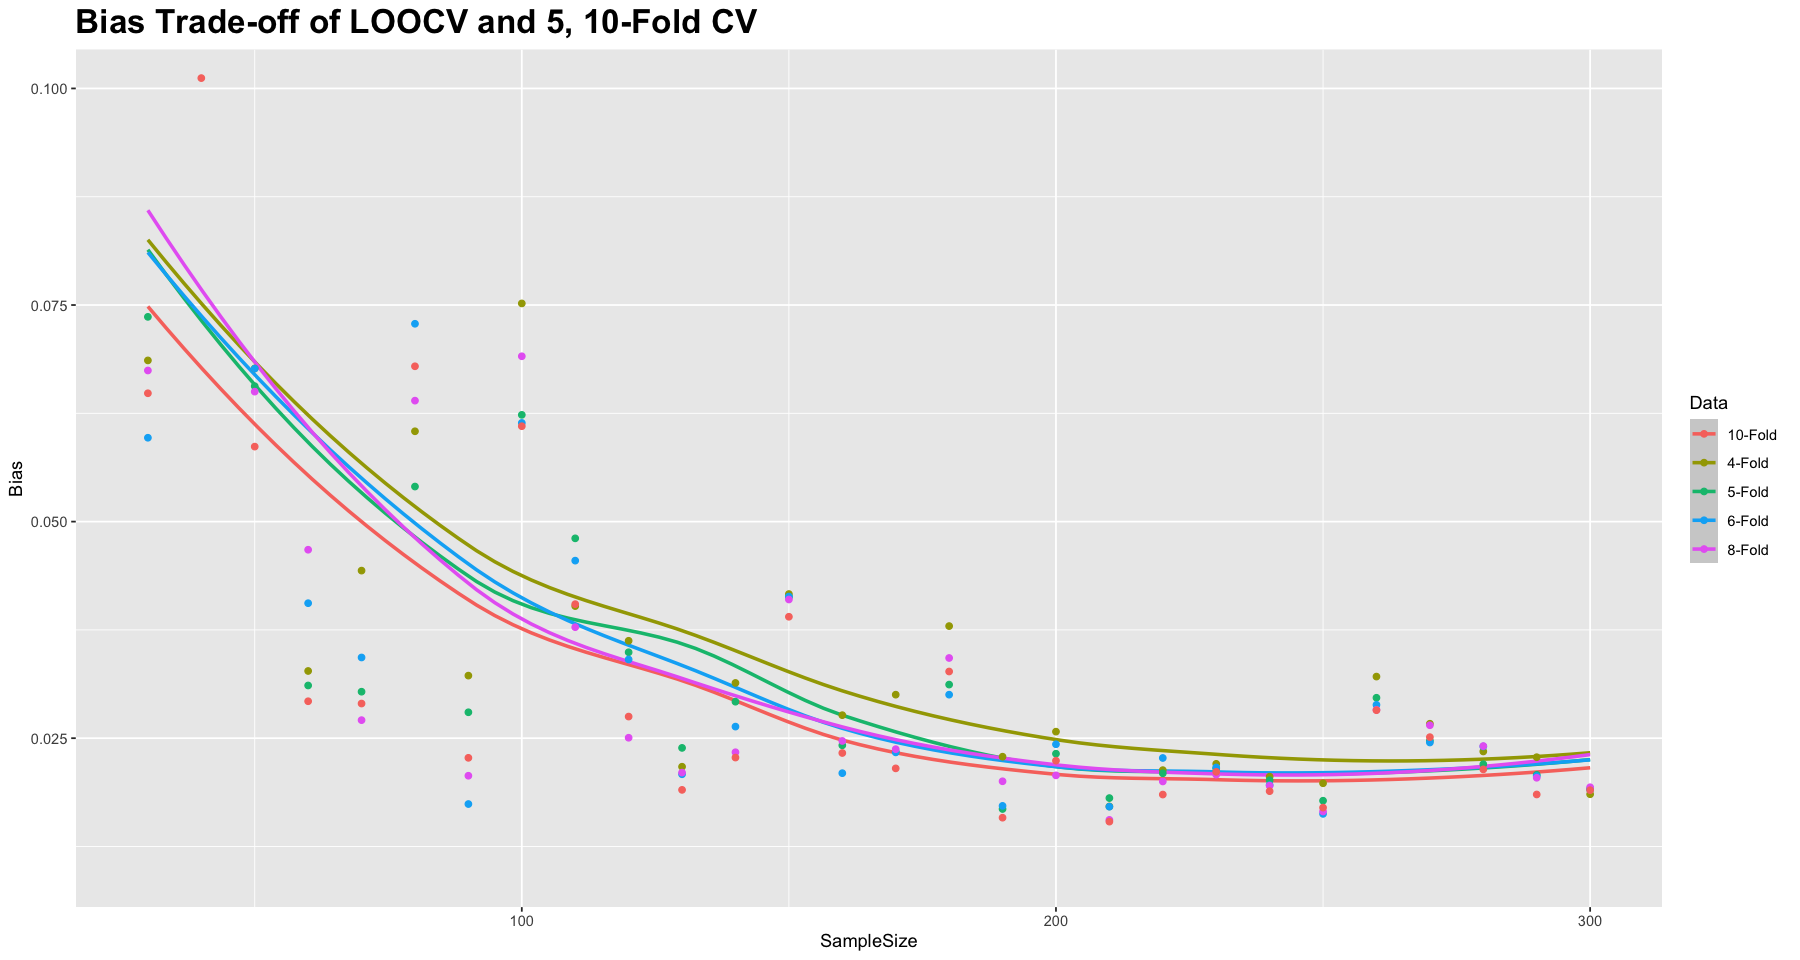

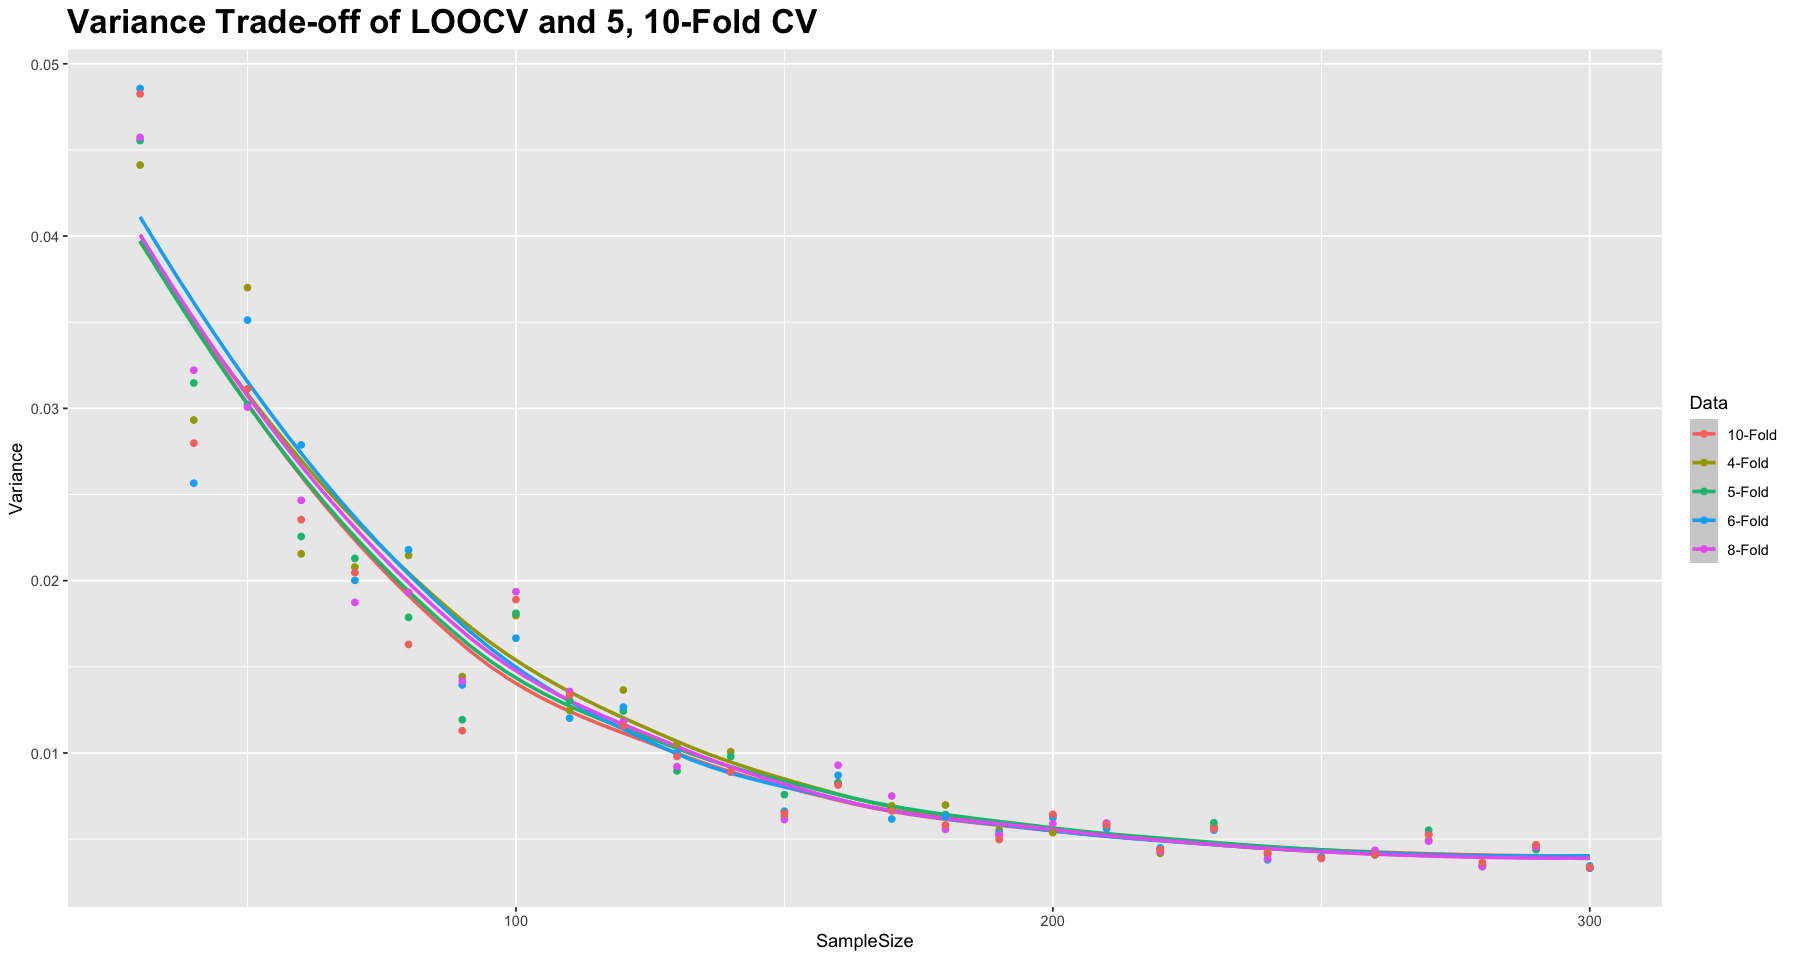

In [77]:
# All the result are organized in a trade-off matrix which will be used to plot graphs
df_tradeoff <- data.frame(c(rep("4-Fold",length(sample_size)),
                            rep("5-Fold",length(sample_size)),
                            rep("6-Fold",length(sample_size)),
                            rep("8-Fold",length(sample_size)),
                            rep("10-Fold",length(sample_size))),
    c(bias_matrix[,1],bias_matrix[,2],bias_matrix[,3],
     bias_matrix[,4],bias_matrix[,5]),
    c(var_matrix[,1],var_matrix[,2],var_matrix[,3],
     var_matrix[,4],var_matrix[,5]),
    rep(sample_size,dim(iterations[[1]])[2]))
colnames(df_tradeoff)<-c("Data","Bias","Variance","SampleSize")

# Plot the Bias against Sample Sizes
ggplot(data=df_tradeoff, aes(x=SampleSize, y=Bias, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    coord_cartesian(ylim=c(0.01,0.1)) +
    ggtitle("Bias Trade-off of LOOCV and 5, 10-Fold CV") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Variance against Sample Sizes
ggplot(data=df_tradeoff, aes(x=SampleSize, y=Variance, group=Data, colour=Data)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0, 0.05), xlim=c(0, 300)) +
    ggtitle("Variance Trade-off of LOOCV and 5, 10-Fold CV") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)


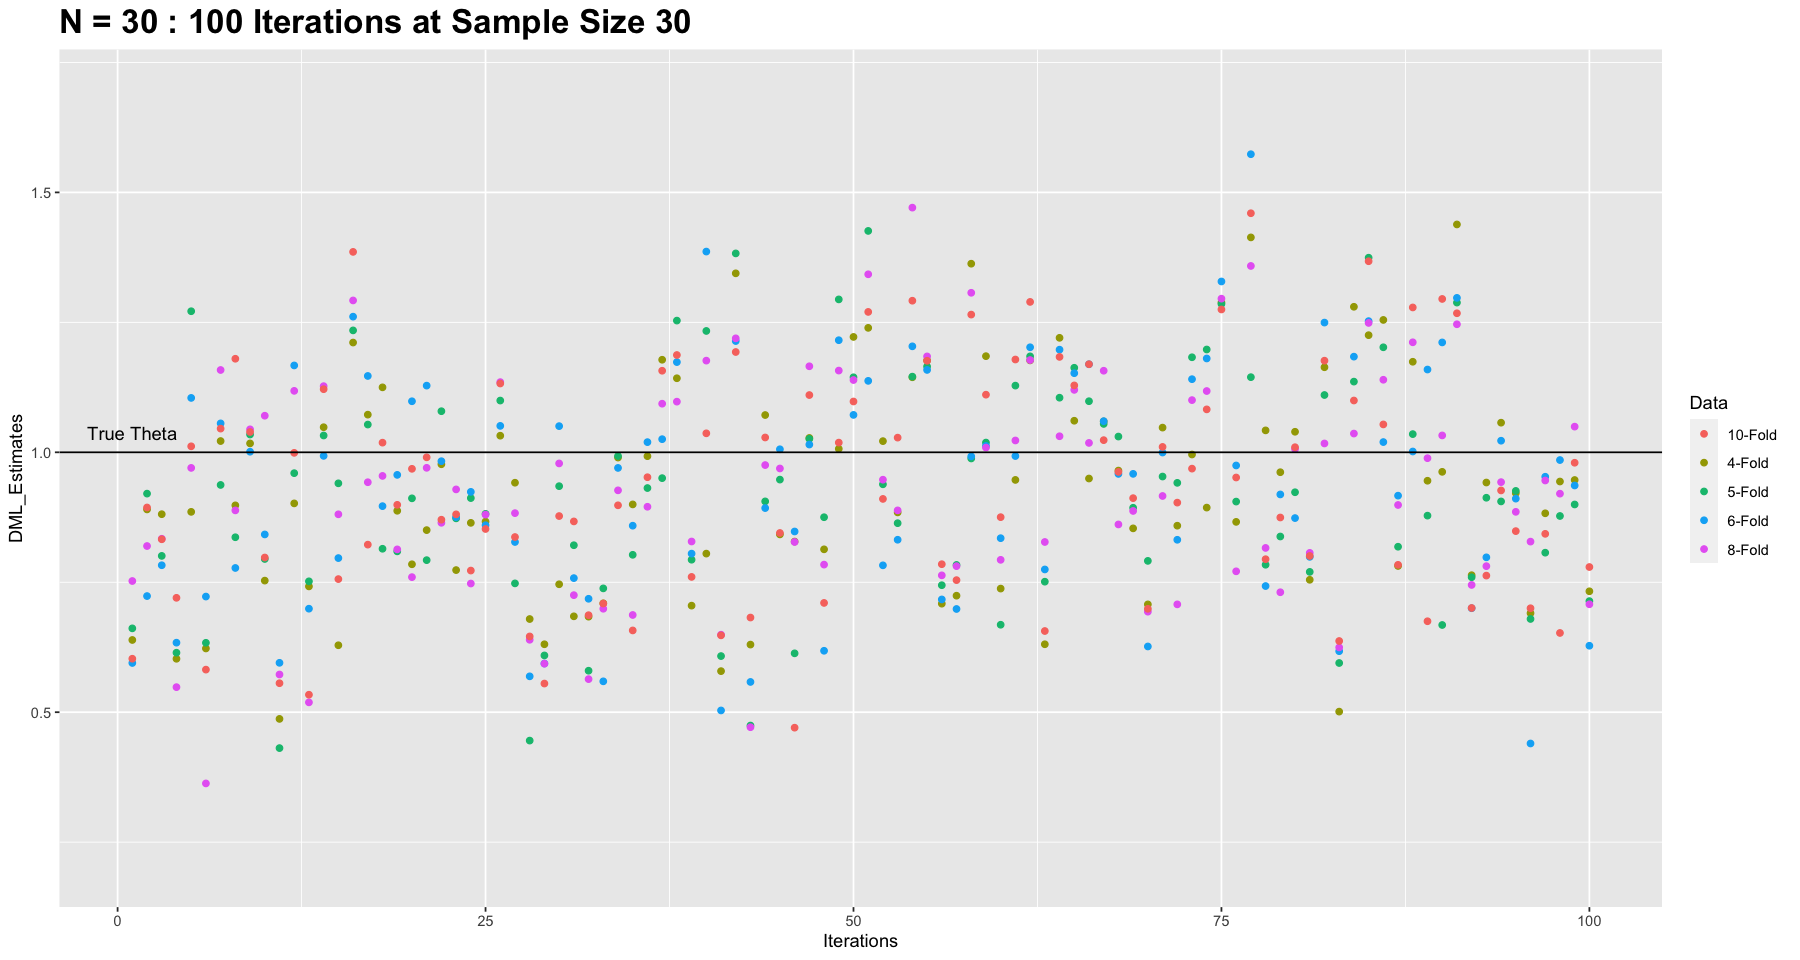

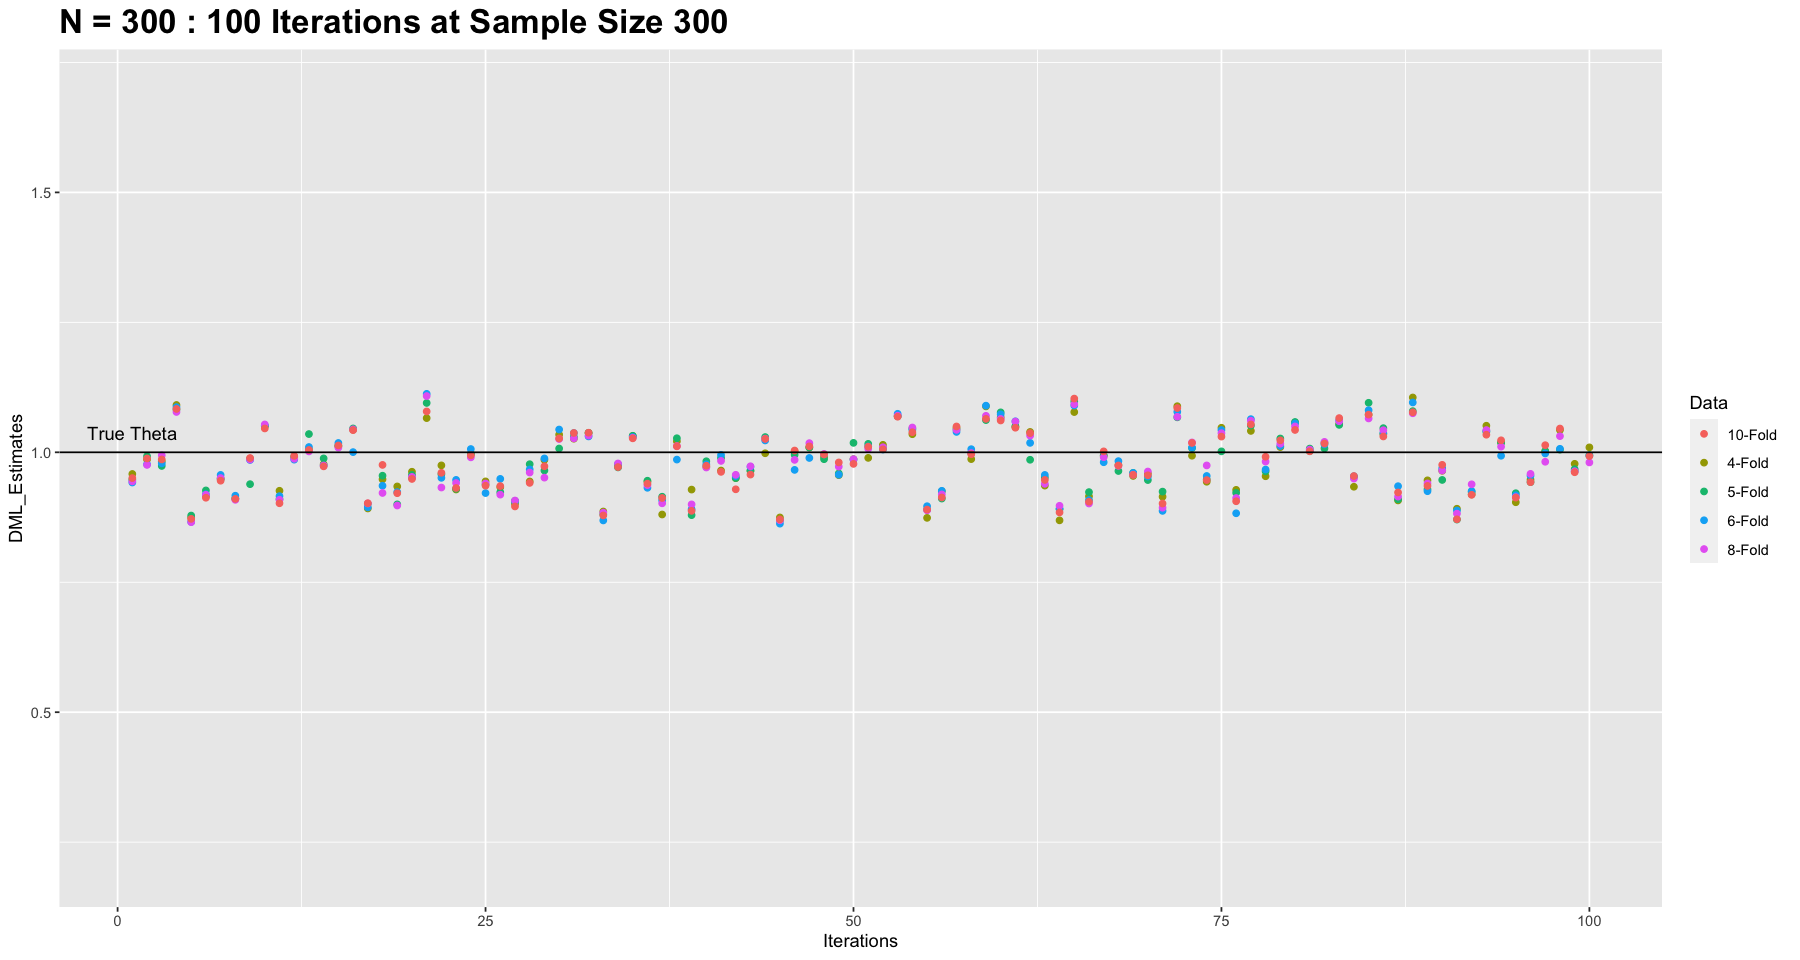

In [65]:
i = 1
df_errors <- data.frame(c(rep("4-Fold",n_rep), rep("5-Fold",n_rep),rep("6-Fold",n_rep),
                          rep("8-Fold",n_rep), rep("10-Fold",n_rep)),
    rep(1:n_rep,5),c(matrix(iterations[[i]],n_rep,5)[,1],
                     matrix(iterations[[i]],n_rep,5)[,2],
                     matrix(iterations[[i]],n_rep,5)[,3],
                     matrix(iterations[[i]],n_rep,5)[,4],
                     matrix(iterations[[i]],n_rep,5)[,5]))
colnames(df_errors)<-c("Data","Iterations","DML_Estimates")

# Plot the Errors when N = 30
ggplot(data=df_errors, aes(x=Iterations, y=DML_Estimates, group=Data, colour=Data)) +
   # geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level=0.01) +
    geom_point() + 
    geom_hline(yintercept = 1) +
    annotate("text",min(df_errors$Iterations),1, vjust = -1, label = "True Theta") +
    coord_cartesian(ylim=c(0.2,1.7)) +
    ggtitle("N = 30 : 100 Iterations at Sample Size 30 ") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

i = 28
df_errors <- data.frame(c(rep("4-Fold",n_rep), rep("5-Fold",n_rep),rep("6-Fold",n_rep),
                          rep("8-Fold",n_rep), rep("10-Fold",n_rep)),
    rep(1:n_rep,5),c(matrix(iterations[[i]],n_rep,5)[,1],
                     matrix(iterations[[i]],n_rep,5)[,2],
                     matrix(iterations[[i]],n_rep,5)[,3],
                     matrix(iterations[[i]],n_rep,5)[,4],
                     matrix(iterations[[i]],n_rep,5)[,5]))
colnames(df_errors)<-c("Data","Iterations","DML_Estimates")

# Plot the Errors when N = 30
ggplot(data=df_errors, aes(x=Iterations, y=DML_Estimates, group=Data, colour=Data)) +
   # geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level=0.01) +
    geom_point() + 
    geom_hline(yintercept = 1) +
    annotate("text",min(df_errors$Iterations),1, vjust = -1, label = "True Theta") +
    coord_cartesian(ylim=c(0.2,1.7)) +
    ggtitle("N = 300 : 100 Iterations at Sample Size 300") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)